In [70]:
import numpy as np
import pandas as pd
import sklearn
import os


In [71]:
df_full = pd.read_csv('temp/covid19_complete_feature&annotation.csv')
df_full.head()

,id,recommendation_expert,recommendation_consumer_1,recommendation_consumer_2,undersitandability_expert,medically_informative_expert,information_accuracy_expert,understandability_consumer_1,medical_information_consumer_1,understandability_consumer_2,...,dislikeRate,commentCount,favoriteCount,channelSubscriberCount,channelViewCount,channelCount,channelVideoCount,max_cos_sim_des,max_cos_sim_title,max_cos_sim_tran
0,0pVEO0bkreA.mp4,1,1,0,1,0,1,1,0,0,...,0.000000,0,0,0,1595676,0,250,0.316228,0.353553,0.000000
1,UEoWRXJT_4I.mp4,0,0,1,1,0,0,1,0,1,...,0.000000,0,0,11600,1290325,0,1411,0.280056,0.333333,0.000000
2,1mKITi1D0p0.mp4,1,1,1,1,1,1,1,1,1,...,0.000309,0,0,13200,25348907,0,712,0.000000,0.577350,0.069505
3,7tgm8KBlCtE.mp4,1,1,1,1,1,1,1,1,1,...,0.000428,29,0,796,841142,0,1043,0.190693,0.353553,0.080064
4,1Yn0pk22pVM.mp4,1,1,1,1,1,1,1,1,1,...,0.000300,0,0,123000,70006556,0,1523,0.190117,0.377964,0.123797


In [72]:
id = df_full["id"].values.tolist()
label = df_full["recommendation_expert"].values.tolist()
item = list(zip(id, label))
covid_dict = dict(item)

In [73]:
import json
data_list = []
for filename in os.listdir('temp/covid-feature'):
    id = filename.split(".")[0] + '.mp4'
    if id in covid_dict.keys():
        file_path = os.path.join('temp/covid-feature', filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
        data['label'] = covid_dict[id]
        data_list.append(data)
        
df = pd.DataFrame(data_list)
df['channel_subscribers'] = df['channel_subscribers'].astype(int)
# Check the data type of a specific column
print(df.dtypes)
print(df.shape)
    

id                           object
hasTags                       int64
num_of_tags                   int64
tags                         object
hasDescription                int64
channel_subscribers           int64
accreditationTag              int64
duration                    float64
publish_days                  int64
num_of_shots                  int64
num_of_objects                int64
text_confidence             float64
transcription confidence    float64
desc_words                    int64
desc_uni                      int64
desc_sen                      int64
desc_act                      int64
desc_sum                      int64
desc_trans                    int64
desc_ari                    float64
tran_words                    int64
tran_uni                      int64
tran_sen                      int64
tran_act                      int64
tran_sum                      int64
tran_trans                    int64
tran_ari                    float64
desc_mer                    

Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.24      0.37        21
           1       0.60      0.96      0.74        25

    accuracy                           0.63        46
   macro avg       0.72      0.60      0.55        46
weighted avg       0.71      0.63      0.57        46

Random Forest:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52        21
           1       0.60      0.60      0.60        25

    accuracy                           0.57        46
   macro avg       0.56      0.56      0.56        46
weighted avg       0.57      0.57      0.57        46

XGBoost:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55        21
           1       0.63      0.68      0.65        25

    accuracy                           0.61        46
   macro avg       0.60      0.60      0.60        46
weighted avg       0.61      

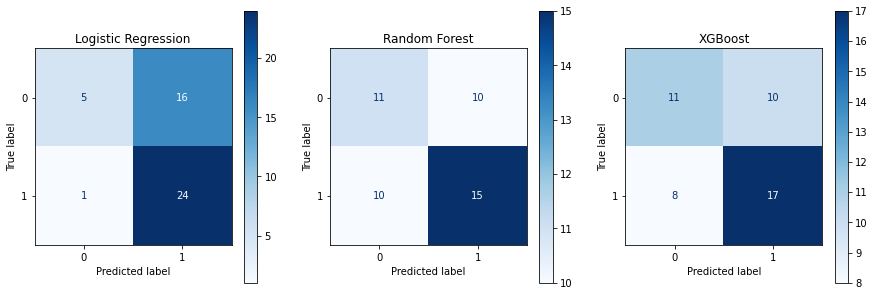

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['id', 'label', 'tags'], axis=1), df['label'], test_size=0.3, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Print classification reports for each model
print('Logistic Regression:')
print(classification_report(y_test, lr_pred))

print('Random Forest:')
print(classification_report(y_test, rf_pred))

print('XGBoost:')
print(classification_report(y_test, xgb_pred))

# Plot confusion matrices for each model
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title('Logistic Regression')
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, ax=axs[0], cmap=plt.cm.Blues, normalize=None)

axs[1].set_title('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, normalize=None)

axs[2].set_title('XGBoost')
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=axs[2], cmap=plt.cm.Blues, normalize=None)

plt.show()
